In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd

%matplotlib inline 

<h2>Prepare inputs</h2>
<h4>Simple model. </h4>
Inputs: name (DSID, scope, ...), panda jobs in last x days, replica used in last x days, users in last x days <br> 
Output: used/not used in next x days<br><br>

- add all data for popularity measurement: sum up over panda ids, replicas, users
- add data for prediction: calculate number of accessed



<h3>First, open files</h3>


In [2]:
#Open files and returns a dictionary of dataframes, key is date
def openFiles(start, end):
    
    dt = start
    dataFrames = {}
    step = datetime.timedelta(days=1)
    
    #loop over all results
    while dt < end:
    
        filename = 'DataPopularity_data/store_'+str(dt)+'.h5'
        df = pd.read_hdf(filename, 'result')       
        dataFrames[dt]=df
        dt += step     
    
    #print(dataFrames)
    return dataFrames

In [3]:
#open files and create dictionary of DataFrames, key is date
start = datetime.date(2016, 5, 3)          # measurement: starting date
ndays = 365                               # Total range of input data

dataFrames = openFiles(start, start+ datetime.timedelta(days=int(ndays)) )
print(len(dataFrames))

365


<h3>Then, create dataframes with data from last 7 days (summed over site, user, pandaids), and add new column with number of accesses for next 7 days</h3>


In [12]:
#merge dataframes used for popularity measurement (used for inputs)

def mergeDF_measurement(df, df_new):
    #print('Before')
    #display(df.shape)
    concatenated = pd.concat([df, df_new]) 
    #print('After')
    
    #drop date, sum over pandaids, sites, users
    result = concatenated.groupby(['name','type','scope']).agg({"pandaid": np.sum, "user": np.sum,  "site": np.sum}).reset_index()    
    #display(df_new.shape)
    #display(result.shape)
    
    return result

In [13]:
#merge dataframes used for prediction (used for outputs)

def mergeDF_prediction(df, df_new):
    #print('Before')
    #display(df.shape)
    #display(df_new.shape)
    
    #save only interesting columns and rename
    df_new = df_new[['name', 'pandaid']] 
    df_new = df_new.rename(index=str, columns={"pandaid":"accessed"})
    
    #merge and sum over accessed
    result = pd.merge(df, df_new, how='left', on=['name'])  
    #result = df.add(df_new).combine_first(df)
    
    #remove double access column created by merging: is there a smarter way?
    if 'accessed_x' in result.columns:
        result['accessed']=result['accessed_x']+result['accessed_y']
        result = result.drop('accessed_x', axis=1)
        result = result.drop('accessed_y', axis=1)                
                
    #print('After')
    #display(result.shape)    
    return result

In [14]:
#merge dataframes over all time range (popularity measurement+prediction) -> input+output

def mergeDF(dataFrames, start, time_meas, time_pred):

    end_meas = start + datetime.timedelta(days=time_meas)       # measurement: end date
    end_pred = end_meas + datetime.timedelta(days=time_pred)     # prediction: end date
    step = datetime.timedelta(days=1)
        
    dt = start
    
    #loop over all results
    while dt < end_pred:
    
        df = dataFrames[dt]
        #print(df)
    
        if dt == start: #start with first dataframe
            #print('measurement '+dt.strftime('%Y-%m-%d'))
            df_new = df
        elif dt < end_meas: # add measurement data, just the same as first dataframe
            #print('measurement '+dt.strftime('%Y-%m-%d'))
            df_new = mergeDF_measurement(df_new ,df)
        else: # add prediction, for each dataset, just add accessed
            #print('prediction '+dt.strftime('%Y-%m-%d'))
            df_new = mergeDF_prediction(df_new,df)        
        
        dt += step     
        
    return df_new

0/363 10/363 20/363 30/363 40/363 50/363 60/363 70/363 80/363 90/363 100/363 110/363 120/363 130/363 140/363 150/363 160/363 170/363 180/363 190/363 200/363 210/363 220/363 230/363 240/363 250/363 260/363 270/363 280/363 290/363 300/363 310/363 320/363 330/363 340/363 350/363 360/363 
Interval: 1


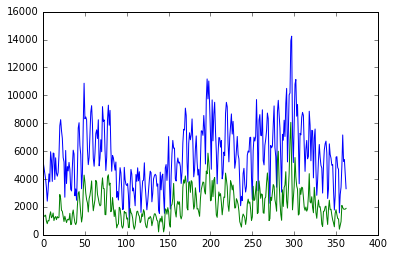

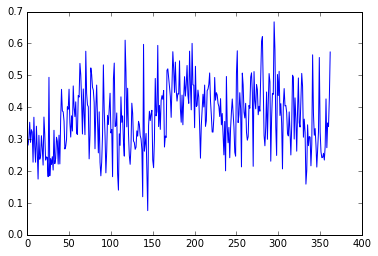

0/351 10/351 20/351 30/351 40/351 50/351 60/351 70/351 80/351 90/351 100/351 110/351 120/351 130/351 140/351 150/351 160/351 170/351 180/351 190/351 200/351 210/351 220/351 230/351 240/351 250/351 260/351 270/351 280/351 290/351 300/351 310/351 320/351 330/351 340/351 350/351 
Interval: 7


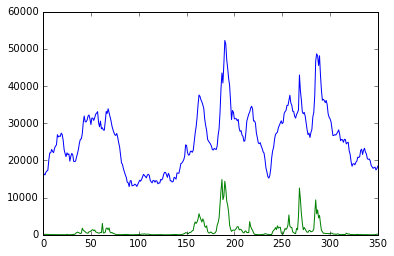

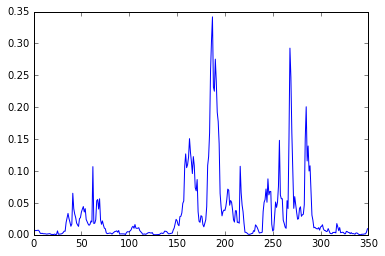

0/339 10/339 20/339 30/339 40/339 50/339 60/339 70/339 80/339 90/339 100/339 110/339 120/339 130/339 140/339 150/339 160/339 170/339 180/339 190/339 200/339 210/339 220/339 230/339 240/339 250/339 260/339 270/339 280/339 290/339 300/339 310/339 320/339 330/339 
Interval: 13


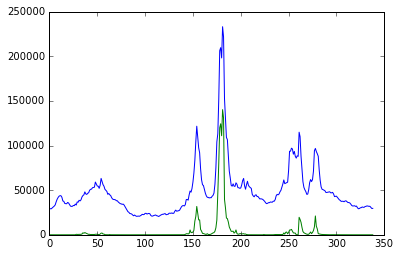

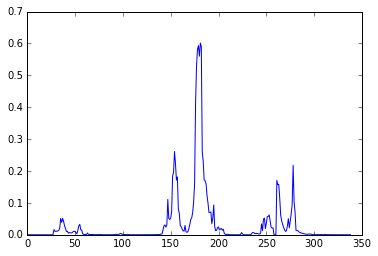

In [7]:
#study popularity as function of measurement time

time_meas = 14                             # popularity measurement: # of days
time_pred = time_meas                      # popularity prediction: # of days    
time_step = 6                              # time step for changing measurement period     

for i in np.arange(1, time_meas+1, time_step):
    
    Total = []
    Accessed = []
    Ratio = []
    actual_ndays = ndays - i - i  # set actual measument+observation period not to go out of bounds
    
    #print('Start processing '+str(actual_ndays)+' days')

    for n in np.arange(0, actual_ndays, 1):
 
        #vary starting time    
        df_new = mergeDF(dataFrames, start+ datetime.timedelta(days=int(n)) , int(i), int(i))
        if not n%10:  print(str(n)+'/'+str(actual_ndays), end=" ") 
        #display(df_new.sort_values('pandaid',ascending=False).head(10))
        #display(df_new.sort_values('accessed',ascending=False).head(10))

        total = df_new[df_new['pandaid'] >=1].index.tolist()
        accessed = df_new[df_new['accessed'] >=1].index.tolist()    
        #print(str(start)+ ' Total: '+str(len(total))+' accessed: '+str(len(accessed)))
        Total.append(len(total))
        Accessed.append(len(accessed))
        Ratio.append(len(accessed)/len(total))

    print('\n'+'Interval: '+str(i))
    plt.plot(Total)
    plt.plot(Accessed)
    plt.show()

    plt.plot(Ratio)
    plt.show()    
    

In [8]:
time_meas = 14                             # popularity measurement: # of days
time_pred = time_meas                      # popularity prediction: # of days    
i = 7                                      # popularity prediction: # of days 

actual_ndays = ndays - i - i  # set actual measument+observation period not to go out of bounds
    
#print('Start processing '+str(actual_ndays)+' days')

for n in np.arange(0, actual_ndays, 1):
 
    #vary starting time    
    df_new = mergeDF(dataFrames, start+ datetime.timedelta(days=int(n)) , int(i), int(i))
    if not n%10:  print(str(n)+'/'+str(actual_ndays), end=" ") 
    #display(df_new.sort_values('pandaid',ascending=False).head(10))
    #display(df_new.sort_values('accessed',ascending=False).head(10))

    total = df_new[df_new['pandaid'] >=1].index.tolist()
    accessed = df_new[df_new['accessed'] >=1].index.tolist()    

0/351 10/351 20/351 30/351 40/351 50/351 60/351 70/351 80/351 90/351 100/351 110/351 120/351 130/351 140/351 150/351 160/351 170/351 180/351 190/351 200/351 210/351 220/351 230/351 240/351 250/351 260/351 270/351 280/351 290/351 300/351 310/351 320/351 330/351 340/351 350/351 

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


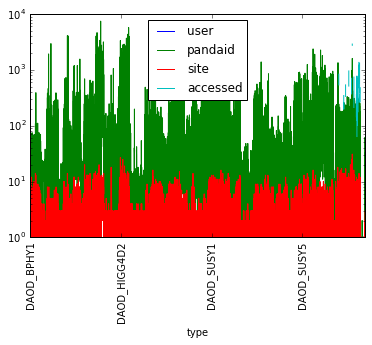

In [9]:
#plot
df_new.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [15]:
#display(df_new.sort_values('pandaid',ascending=False).head(10))
display(df_new.sort_values('accessed',ascending=False).head(10))

,name,type,scope,user,pandaid,site,accessed
18325,mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...,DAOD_TOPQ1,mc15_13TeV,12,1595,31,2904.0
18326,mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...,DAOD_TOPQ1,mc15_13TeV,11,1607,27,2759.0
5252,data16_13TeV.00304128.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,6,253,11,1956.0
4328,data16_13TeV.00302872.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,6,299,16,1716.0
7030,data16_13TeV.00307732.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,6,252,10,1626.0
7144,data16_13TeV.00308047.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,6,219,12,1595.0
7107,data16_13TeV.00307935.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,5,171,7,1434.0
5472,data16_13TeV.00304337.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,7,196,12,1412.0
7354,data16_13TeV.00309516.physics_Main.merge.DAOD_...,DAOD_TOPQ1,data16_13TeV,7,173,11,1410.0
14895,mc15_13TeV.364161.Sherpa_221_NNPDF30NNLO_Wmunu...,DAOD_TOPQ1,mc15_13TeV,4,229,7,1361.0


<h3>Still some arrangement to do</h3>
extract p_tags, DSID, convert accessed to binary

In [17]:
body = 'http://atlas-kibana.mwt2.org:5601/app/kibana#/dashboard/FL-Analysis-User'
print(body)

http://atlas-kibana.mwt2.org:5601/app/kibana#/dashboard/FL-Analysis-User


<h3>Now, prepare inputs for machine learning</h3>

first columns need to be inputs x_i, last column output y = accessed (1 or 0)

In [130]:
index = df_new[df_new['name'] == 'mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75_nonallhad.merge.DAOD_TOPQ1.e5458_s2726_r7772_r7676_p2952_tid10298091_00'].index.tolist()
index[0]

33331